In [6]:
import numpy as np
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.utils import np_utils
from PIL import Image    

In [7]:
def add_label_dimension(output_image, classes):
    heigth, width = output_image.shape[0], output_image.shape[1]
    image_labeled = np.zeros((heigth, width, classes))
    for y in range(heigth):
        for x in range(width):
            image_labeled[y, x, output_image[y][x]] = 1
    return image_labeled

In [8]:
def parse_location(path):
    return "/".join(path.split("/")[-2:])

def read_image_batch(log_file, classes, training_size=50):
    location = "/".join(log_file.split("/")[:-1])
    file_list = open(log_file).readlines()

    inputs = []  
    outputs = []
    for index, line in enumerate(file_list):
        line = line.strip().split()
            
        input_image = np.array(Image.open(location + "/" + parse_location(line[0])))
        inputs.append(input_image)
            
        output_image = add_label_dimension(np.array(Image.open(location + "/" + parse_location(line[1]))), classes)
        outputs.append(output_image)
        
        if(len(outputs) >= training_size):
            break        
    return np.array(inputs), np.array(outputs)

In [9]:
input_shape = (360, 480, 3)
classes = 12
epochs = 200

In [10]:
X, y = read_image_batch("/root/comma/photos/701_StillsRaw_full/SegNet-Tutorial/CamVid/train.txt", classes)

In [11]:
X_test, y_test = read_image_batch("/root/comma/photos/701_StillsRaw_full/SegNet-Tutorial/CamVid/test.txt", classes)

In [12]:
y = np.reshape(y, (y.shape[0], input_shape[0] * input_shape[1], classes))
y_test = np.reshape(y, (y.shape[0], input_shape[0] * input_shape[1], classes))

In [13]:
image_input = Input(shape=input_shape)
x = image_input

# Encoder
x = Conv2D(64, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(512, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

# Decoder
x = Conv2D(512, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(256, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(classes, kernel_size=(1, 1), padding="valid")(x)
x = Reshape((input_shape[0]*input_shape[1], classes))(x)
x = Activation("softmax")(x)
model = Model(image_input, x)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [16]:
save_weights = "segnet"
#model.save_weights('%s.hdf5' % (save_weights))
model.load_weights("%s.hdf5" % (save_weights))

In [17]:
#model.fit(X, y, batch_size=batch_size, epochs=epochs)

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

# https://github.com/alexgkendall/SegNet-Tutorial/blob/ee9b5ae53d5897171573d562a76c7796ba4f3bba/Scripts/test_segmentation_camvid.py
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(segment_image):
    global classes
    r = segment_image.copy()
    g = segment_image.copy()
    b = segment_image.copy()
    for l in range(classes):
        r[segment_image == l] = label_colours[l,0]
        g[segment_image == l] = label_colours[l,1]
        b[segment_image == l] = label_colours[l,2]
    rgb = np.zeros((segment_image.shape[0], segment_image.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    return rgb

In [19]:
test_index = 30
example_test_X = X_test[test_index]
example_test_y = visualize(np.argmax(y_test[test_index],axis=1).reshape((360,480)))

new_size = (1,) + input_shape
example_model_y = visualize(np.argmax(model.predict(example_test_X.reshape(new_size))[0],axis=1).reshape((360,480)))

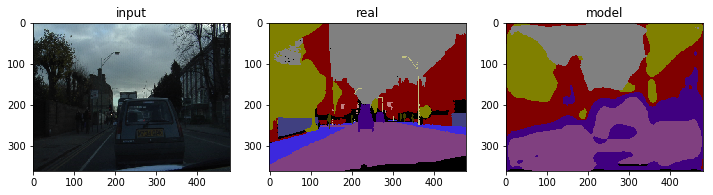

In [20]:
figure, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].set_title("input")
axes[0].imshow(example_test_X)
axes[1].set_title("real")
axes[1].imshow(example_test_y)
axes[2].set_title("model")
axes[2].imshow(example_model_y)